In [39]:
from pathlib import Path
import numpy as np
import csv
import os
from mmaction.datasets.custom_metrics import split_cluster_acc_v2
import matplotlib.pyplot as plt

In [2]:
p_pkl = Path('work_dirs/train_output/cdar/03_simnreal/02_k400_babel/02_timesformer/warmup/in1k/27900__k2b-tsf-warmup-in1k/0/20230129-105851/best_pred.pkl')
# p_pkl = Path('work_dirs/train_output/cdar/03_simnreal/01_babel_k400/03_gcd/default/default/28017__b2k-gcd/1/20230130-104954/best_pred.pkl')
pred = np.array(np.load(p_pkl, allow_pickle=True))
pred.shape

(25059, 768)

In [3]:
p_ann_source = Path('data/_filelists/k400/processed/filelist_k400_train_closed.txt')
p_ann_target = Path('data/_filelists/babel/processed/filelist_babel_train_open_all.txt')
# p_ann_source = Path('data/_filelists/babel/processed/filelist_babel_train_closed.txt')
# p_ann_target = Path('data/_filelists/k400/processed/filelist_k400_train_open_all.txt')
with p_ann_source.open() as f1, p_ann_target.open() as f2:
    gt_source = np.array([int(label) for *_, label in csv.reader(f1, delimiter=' ')])
    gt_target = np.array([int(label) for *_, label in csv.reader(f2, delimiter=' ')])
len(gt_source), len(gt_target), len(gt_source) + len(gt_target)

(14883, 10176, 25059)

In [4]:
feat_source, feat_target = pred[:len(gt_source)], pred[len(gt_source):]
feat_source.shape, feat_target.shape

((14883, 768), (10176, 768))

In [5]:
from slurm.gcd4da.commons.kmeans import SSKMeansTrainer as SSKMeans
num_old_classes = 12
num_all_classes = 20
# num_all_classes = 27
sskmeans = SSKMeans(ks=num_all_classes, autoinit=False, num_known_classes=num_old_classes, verbose=False)
sskmeans.Xs = {
    'train_source': feat_source,
    'train_target': feat_target,
    'valid': feat_target,
    'test': feat_target,
}
sskmeans.anns = {
    'train_source': gt_source,
    'train_target': gt_target,
    'valid': gt_target,
    'test': gt_target,
}
sskmeans.train()

In [7]:
pred_source = sskmeans.predict(sskmeans.model_best)['train_source']
pred_target = sskmeans.predict(sskmeans.model_best)['test']
old_mask = (gt_source < num_old_classes)
total_acc, old_acc, new_acc, conf, ind_map = split_cluster_acc_v2(gt_source, pred_source, old_mask, True, True)
with np.printoptions(threshold=np.inf, linewidth=np.inf):
    print(total_acc, old_acc, new_acc)
    print(conf)
    print(ind_map)
old_mask = (gt_target < num_old_classes)
total_acc, old_acc, new_acc, conf, ind_map = split_cluster_acc_v2(gt_target, pred_target, old_mask, True, True)
with np.printoptions(threshold=np.inf, linewidth=np.inf):
    print(total_acc, old_acc, new_acc)
    print(conf)
    print(ind_map)

0.7924477591883357 0.7924477591883357 0
[[1366    0    1    1    0    0    0    0    0    0    0    0    0    0    0    0    0    1    0    2]
 [   0  446    0    2    0    0    0    0    0    0    1    0    0    0    1    0    0    0    0    0]
 [   0    0 1372    1    0    0    0    0    0   10    5    0    0    0    5    0    0    0  314   12]
 [   0    0    0  609    0    0    1    0    0    2    0    0    0    0  357    0    0    0    0  519]
 [   0    0    0    0  408    0    0    0    0    0    0    6    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0 1612    0    0    0    0    0    0    0    0    0    1    0 1093    0    1]
 [   0    0    0    0    0    0 1258    0    0    0    1    0    0    0    0    0  468    0    0    0]
 [   0    1    0    0    1    0    0  854    0    0    0   17    0    0    0    1    0    2    2    2]
 [   0    1    0    0    2    0    2    0 1171    0   66    0    0    2    0    1    2   23    0  136]
 [   0    0    0    0    0    0  

In [32]:
from collections import Counter
p_k400_scene_pkl = Path('data/_filelists/k400/processed/scene/filelist_scene_k400_train_open_all.pkl')
with open('data/_filelists/k400/processed/filelist_k400_train_open_all.txt') as f:
    ann = np.array([int(line[-1]) for line in csv.reader(f, delimiter=' ')])
    k400_scene_pkl = np.array(np.load(p_k400_scene_pkl, allow_pickle=True))[ann<num_old_classes]
    print(k400_scene_pkl.shape, gt_source.shape)

def get_classnames():
    # load the class label
    file_name = 'categories_places365.txt'
    if not os.access(file_name, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
        os.system('wget ' + synset_url)
    classes = list()
    with open(file_name) as class_file:
        for line in class_file:
            classes.append(line.strip().split(' ')[0][3:])
    classes = np.array(classes)
    return classes

scenenames = get_classnames()
for scene_idx, freq in Counter(k400_scene_pkl.argmax(axis=1)).items():
    print(f'{scenenames[scene_idx]:20} {freq}')

(14883, 365) (14883,)
campus               486
jewelry_shop         5857
clothing_store       4905
gazebo/exterior      1657
hospital             842
gift_shop            884
museum/indoor        227
building_facade      19
art_gallery          6


In [59]:
ind = np.array([ind_map[i] for i in range(num_all_classes)])
pred_source_shuffled = ind[pred_source]
for i in range(num_all_classes):
    feats = cluster_scene_features = k400_scene_pkl[pred_source_shuffled==i]
    feats -= feats.mean(axis=0)
    distances = np.einsum('ij,ij->i', feats, feats) ** .5
    inertia = distances.mean()
    print(f'{i:2d}  N = {feats.shape[0]:4d}, {inertia:.1f}')
inertia.mean(), total_acc, old_acc, new_acc  # source scene inertia, target 성능

 0 N = 1366, 21.1
 1 N =  448, 25.6
 2 N = 1373, 23.3
 3 N =  628, 24.4
 4 N =  411, 26.9
 5 N = 1612, 27.3
 6 N = 1261, 25.4
 7 N =  316, 24.5
 8 N = 1171, 26.1
 9 N =  941, 26.7
10 N =  563, 26.3
11 N =    3, 22.1
12 N =    1, 0.0
13 N =  470, 26.5
14 N =    3, 24.1
15 N = 1306, 26.4
16 N =  363, 23.8
17 N = 1120, 26.6
18 N =  855, 26.0
19 N =  672, 25.0


(25.01477, 0.41676493710691825, 0.08774890313871077, 0.5519201441841121)

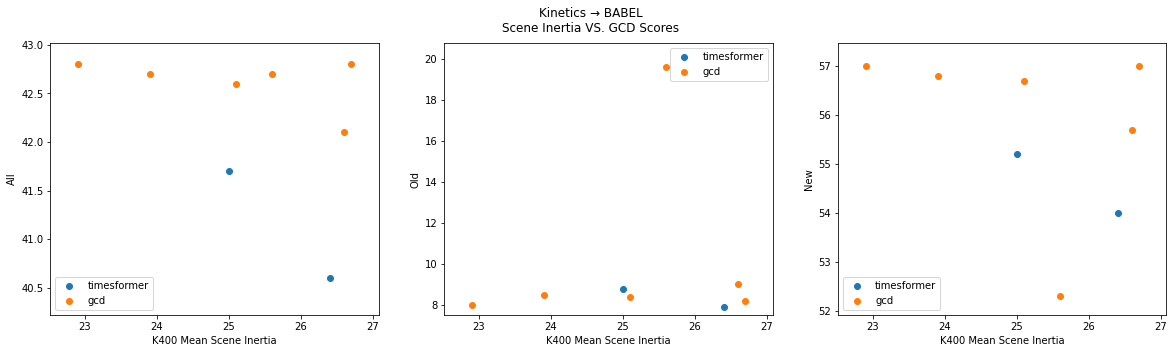

In [26]:
import json
with open('/data/hyogun/repos/haawron_mmaction2/analysis/hi.json') as f:
    scores = json.load(f)

import matplotlib.pyplot as plt

score_limits = np.zeros((2, 4))
score_limits[0] += 100  # to get min
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for model_name, model_scores in scores.items():
    model_scores = np.array(model_scores, dtype=float)
    for i in range(3):
        axes[i].scatter(model_scores[:,-1], model_scores[:,i], label=model_name)
    score_limits[0] = np.minimum(score_limits[0], model_scores.min(axis=0))
    score_limits[1] = np.maximum(score_limits[1], model_scores.max(axis=0))
score_names = ['All', 'Old', 'New']
for i, score_name in enumerate(score_names):
    axes[i].set_xlabel('K400 Mean Scene Inertia')
    axes[i].set_ylabel(score_name)
    score_range = score_limits[1] - score_limits[0]
    axes[i].set_xlim(score_limits[0,-1]-.1*score_range[-1], score_limits[1,-1]+.1*score_range[-1])
    axes[i].set_ylim(score_limits[0,i]-.1*score_range[-1], score_limits[1,i]+.1*score_range[i])
    axes[i].legend()
fig.suptitle('Kinetics → BABEL\nScene Inertia VS. GCD Scores')
fig.patch.set_alpha(1.)
plt.show()

In [13]:
u, inv = np.unique(pred_target, return_inverse=True)
pred_target_mapped = np.array([ind_map[x] for x in u])[inv].reshape(pred_target.shape)
pred_target_mapped[:20], pred_target[:20]

(array([14, 14, 12, 12, 14, 14, 12, 11, 14, 14, 11, 12, 12, 12, 12, 14, 11,
        12, 12, 11]),
 array([13, 13, 12, 12, 13, 13, 12, 15, 13, 13, 15, 12, 12, 12, 12, 13, 15,
        12, 12, 15]))

In [18]:
with open('data/labelmaps/simnreal_k400.txt') as f:
    labelnames = np.array([line[1] for line in csv.reader(f, delimiter=' ') if line])
labelnames

array(['jump', 'run', 'throw', 'kick', 'bend', 'dance', 'clean_something',
       'squat', 'punch', 'crawl', 'clap', 'pick_up', 'driving_car',
       'digging', 'climbing_a_rope', 'cutting_watermelon', 'golf_driving',
       'pushing_car', 'singing', 'unboxing', 'waxing_legs', 'smoking',
       'sniffing', 'push_up', 'kitesurfing', 'fixing_hair',
       'balloon_blowing'], dtype='<U18')

In [49]:
YELLOW = '\033[93m'
RED = '\033[91m'
END = '\033[0m'
FPS = 30
with p_ann_target.open() as f:
    paths, starts, lengths = zip(*[[path, int(start), int(length)] for path, start, length, _ in csv.reader(f, delimiter=' ')])
for path, start, length, pred, gt in zip(paths, starts, lengths, pred_target_mapped, gt_target):
    s_gt = (YELLOW if gt >= num_old_classes else END) + f'{labelnames[gt]:>24}' + END
    s_pred = (YELLOW if pred >= num_old_classes else END) + f'{labelnames[pred]:<24}' + END
    s_arrow = (RED if pred != gt else END) + f'->' + END
    print(f'data/babel_v1.0_release/renders/{path}.mp4 | {start/FPS:4.1f}s  ~  {(start+length)/FPS:4.1f}s | {s_gt} {s_arrow} {s_pred}')

data/babel_v1.0_release/renders/train/012103.mp4 | 53.8s  ~  56.1s |             golf_driving -> climbing_a_rope         
data/babel_v1.0_release/renders/train/003476.mp4 | 34.0s  ~  35.3s |             golf_driving -> climbing_a_rope         
data/babel_v1.0_release/renders/train/011856.mp4 |  6.7s  ~   7.4s |          climbing_a_rope -> driving_car             
data/babel_v1.0_release/renders/train/002556.mp4 |  1.7s  ~   6.4s |       cutting_watermelon -> driving_car             
data/babel_v1.0_release/renders/train/001098.mp4 |  2.7s  ~   3.9s |              pushing_car -> climbing_a_rope         
data/babel_v1.0_release/renders/train/002953.mp4 | 13.9s  ~  15.5s |                 unboxing -> climbing_a_rope         
data/babel_v1.0_release/renders/train/002850.mp4 | 21.6s  ~  22.3s |                  digging -> driving_car             
data/babel_v1.0_release/renders/train/005513.mp4 |  2.0s  ~   5.9s |          clean_something -> pick_up                 
data/babel_v1.0_release/